In [14]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from typing import *
from sentence_transformers import SentenceTransformer
from faiss import write_index, read_index
import blingfire as bf
import torch
import faiss
import json
import re

In [15]:
train_df = pd.read_csv("/home/clay/research/kaggle/kaggle_llm/data/kaggle-llm-science-exam/train.csv", index_col=0)
wiki_df = pd.read_csv("/home/clay/research/kaggle/kaggle_llm/data/physics_pages_list/physics_pages_formatted.csv", index_col=0)

In [16]:
wc_per_page = wiki_df.groupby("page")[["word_count"]].sum().sort_values("word_count", ascending=False)
black_list = list(wc_per_page.loc[
    (wc_per_page["word_count"] > 10000)
    | (wc_per_page.index.map(lambda x: "list of equations" in x.lower()))
].index)
print(json.dumps(black_list, indent=4))


filtered_wiki_df = wiki_df.loc[~wiki_df["page"].isin(black_list), :].copy()
print(len(wiki_df), len(filtered_wiki_df))

[
    "Galactocentric distance",
    "List of equations in classical mechanics",
    "List of equations in quantum mechanics",
    "List of equations in wave theory",
    "List of equations in fluid mechanics",
    "List of equations in nuclear and particle physics",
    "List of equations in gravitation"
]
4096 4054


In [17]:
filtered_wiki_df.head()

,page,section_title,text,word_count
0,Electric field,Description,The electric field is defined at each point in...,441
1,Electric field,Mathematical formulation,Electric fields are caused by electric charges...,71
2,Electric field,Electrostatic fields,Electrostatic fields are electric fields that ...,37
3,Electric field,Electrodynamic fields,Electrodynamic fields are electric fields whic...,166
4,Electric field,Energy in the electric field,The total energy per unit volume stored by the...,119


In [18]:
sentence_model = "/home/clay/research/kaggle/kaggle_llm/data/sentence_transformer_model"
max_length = 384
batch_size = 16


model = SentenceTransformer(sentence_model, device="cuda")
model.max_seq_length = max_length
model = model.half()

In [19]:
sentences_df = []


for _, row in tqdm(filtered_wiki_df.iterrows(), total=len(filtered_wiki_df)):
    _, sentence_offsets = bf.text_to_sentences_and_offsets(row["text"])
    for i, (start_idx, end_idx) in enumerate(sentence_offsets):
        if (end_idx - start_idx) > 3:
            sentences_df.append({
                "page": row["page"],
                "i_sentence": i,
                "text": row["text"][start_idx: end_idx],
            })

            
sentences_df = pd.DataFrame.from_records(sentences_df)
print(f"extracted: {len(sentences_df)} sentences")

  0%|          | 0/4054 [00:00<?, ?it/s]

extracted: 33207 sentences


In [20]:
sentences_df.head()

,page,i_sentence,text
0,Electric field,0,The electric field is defined at each point in...
1,Electric field,1,The electric field acts between two charges si...
2,Electric field,2,"This is the basis for Coulomb's law, which sta..."
3,Electric field,3,This means that if the source charge were doub...
4,Electric field,4,The electric field can be visualized with a se...


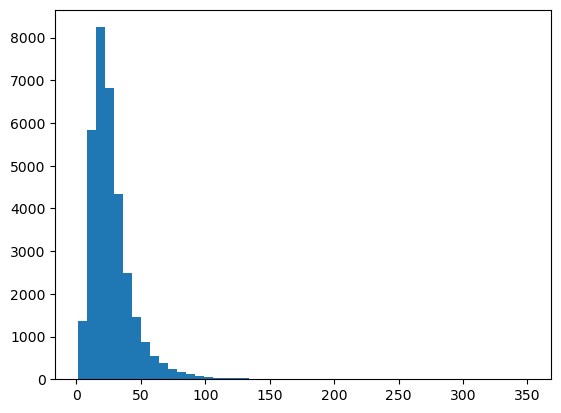

In [39]:
import matplotlib.pyplot as plt


def count_words(text):
    return sum([1 for i in text.split() if len(i) > 0])


_ = plt.hist(sentences_df["text"].apply(count_words), bins=50)

In [44]:
train_df["prompt_and_answer"] = (
    train_df["prompt"]
    + " " + train_df["A"]
    + " " + train_df["B"]
    + " " + train_df["C"]
    + " " + train_df["D"]
    + " " + train_df["E"]
)


choice_embeddings = []


with torch.no_grad():
    question_embeddings = model.encode(
        train_df["prompt_and_answer"].values, 
        batch_size=batch_size, 
        device=0, 
        show_progress_bar=True, 
        convert_to_tensor=True, 
        normalize_embeddings=True,
    ).half()
    question_embeddings = question_embeddings.detach().cpu().numpy()
    
    for choice in ["A", "B", "C", "D", "E"]:
        embeddings = model.encode(
            train_df[choice].values, 
            batch_size=batch_size, 
            device=0, 
            show_progress_bar=True, 
            convert_to_tensor=True, 
            normalize_embeddings=True,
        ).half()
        choice_embeddings.append(embeddings.detach().cpu().numpy())
    
    sentence_embeddings = model.encode(
        sentences_df["text"].values, 
        batch_size=batch_size,
        device=0, 
        show_progress_bar=True, 
        convert_to_tensor=True, 
        normalize_embeddings=True,
    ).half()
    sentence_embeddings = sentence_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/2076 [00:00<?, ?it/s]

In [45]:
sentence_index = faiss.IndexFlatL2(sentence_embeddings.shape[1])
sentence_index.add(sentence_embeddings)
print(f"{sentence_index.ntotal = }")

sentence_index.ntotal = 33207


In [46]:
k = 3
distance, indices = sentence_index.search(question_embeddings, k)

for i in range(k):
    train_df[f"context_{i}_idx"] = indices[:, i]
    
for i in range(k):
    train_df[f"context_{i}"] = train_df.join(
        sentences_df["text"],
        on=f"context_{i}_idx",
        how="left",
    )["text"]


choice_k = 1
for emb, choice in zip(choice_embeddings, ["A", "B", "C", "D", "E"]):
    choice_distance, choice_indices = sentence_index.search(emb, choice_k)
    for i in range(choice_k):
        train_df[f"context_{choice}_idx"] = choice_indices[:, i]
        train_df[f"context_{choice}"] = train_df.join(
            sentences_df["text"],
            on=f"context_{choice}_idx",
            how="left",
        )["text"]

    
train_df = train_df.drop([f"context_{i}_idx" for i in range(k)], axis=1)
train_df = train_df.drop([f"context_{i}_idx" for i in ["A", "B", "C", "D", "E"]], axis=1)
train_df.head()

,prompt,A,B,C,D,E,answer,prompt_and_answer,context_0,context_1,context_2,total_wc,context_A,context_B,context_C,context_D,context_E
id,,,,,,,,,,,,,,,,,
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,Which of the following statements accurately d...,MOND reduces the discrepancy between the veloc...,Modified Newtonian dynamics (MOND) is a hypoth...,MOND departs from Newton's laws at extremely s...,328,MOND departs from Newton's laws at extremely s...,MOND reduces the discrepancy between the veloc...,MOND departs from Newton's laws at extremely s...,MOND reduces the discrepancy between the veloc...,MOND departs from Newton's laws at extremely s...
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,Which of the following is an accurate definiti...,Many other seemingly disparate systems which a...,Dynamic scaling (sometimes known as Family-Vic...,The litmus test of such self-similarity is pro...,298,Many of these systems evolve in a self-similar...,Many of these systems evolve in a self-similar...,Many other seemingly disparate systems which a...,Many other seemingly disparate systems which a...,Many of these systems evolve in a self-similar...
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,Which of the following statements accurately d...,The actual triskeles symbol of three human leg...,A triskelion or triskeles is an ancient motif ...,While the Greek adjective τρισκελής 'three-leg...,380,"An early flag of Sicily, proposed in 1848, inc...","An early flag of Sicily, proposed in 1848, inc...","An early flag of Sicily, proposed in 1848, inc...","An early flag of Sicily, proposed in 1848, inc...","An early flag of Sicily, proposed in 1848, inc..."
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,What is the significance of regularization in ...,Regularization is the first step towards obtai...,Renormalization is distinct from regularizatio...,Similar regularization arguments work in other...,271,"For instance, in this case, assuming a finite ...",Renormalization is distinct from regularizatio...,"For instance, in this case, assuming a finite ...","For instance, in this case, assuming a finite ...","For instance, in this case, assuming a finite ..."
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,Which of the following statements accurately d...,Several qualitative observations can be made o...,Several qualitative observations can be made o...,The simplest descriptions of diffraction are t...,290,In other words: the smaller the diffracting ob...,In other words: the smaller the diffracting ob...,Several qualitative observations can be made o...,In other words: The smaller the diffracting ob...,In other words: the smaller the diffracting ob...


In [47]:
def count_words(text):
    return sum([1 for i in text.split() if len(i) > 0])


train_df["total_wc"] = (
    train_df["prompt"] 
    + " " + train_df["A"]
    + " " + train_df["B"]
    + " " + train_df["C"]
    + " " + train_df["D"]
    + " " + train_df["E"]
    + " " + train_df["context_0"]
    + " " + train_df["context_1"]
    + " " + train_df["context_2"]
    + " " + train_df["context_A"]
    + " " + train_df["context_B"]
    + " " + train_df["context_C"]
    + " " + train_df["context_D"]
    + " " + train_df["context_E"]
).apply(count_words)


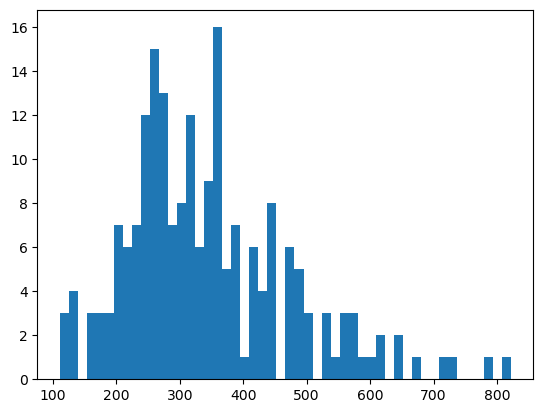

In [48]:
import matplotlib.pyplot as plt


_ = plt.hist(train_df["total_wc"], bins=50)

In [50]:
row = train_df.iloc[1]
print(f"question: {row['prompt']}\n")
print(f"context_0: {row['context_0']}\n")
print(f"context_1: {row['context_1']}\n")
print(f"context_2: {row['context_2']}\n")
print(f"A: {row['A']}\n")
print(f"context_A: {row['context_A']}\n")
print(f"B: {row['B']}\n")
print(f"context_B: {row['context_B']}\n")
print(f"C: {row['C']}\n")
print(f"context_C: {row['context_C']}\n")
print(f"D: {row['D']}\n")
print(f"context_D: {row['context_D']}\n")
print(f"E: {row['E']}\n")
print(f"context_E: {row['context_E']}\n")
print(f"answer: {row['answer']}\n")

question: Which of the following is an accurate definition of dynamic scaling in self-similar systems?

context_0: Many other seemingly disparate systems which are found to exhibit dynamic scaling.

context_1: Dynamic scaling (sometimes known as Family-Vicsek scaling) is a litmus test that shows whether an evolving system exhibits self-similarity.

context_2: The litmus test of such self-similarity is provided by the dynamic scaling.

A: Dynamic scaling refers to the evolution of self-similar systems, where data obtained from snapshots at fixed times exhibits similarity to the respective data taken from snapshots of any earlier or later time. This similarity is tested by a certain time-dependent stochastic variable x.

context_A: Many of these systems evolve in a self-similar fashion in the sense that data obtained from the snapshot at any fixed time is similar to the respective data taken from the snapshot of any earlier or later time.

B: Dynamic scaling refers to the non-evolution o